In [9]:
import autograd.numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from data_utils import load_dataset
from data_utils import plot_digit
from autograd import value_and_grad
from a3_mod import *

# Q1. Logistic Regression
- Plot the loss versus epoch and report learning rates
- train logistic regression model on iris dataset 
- present test accuracy and test log-likelihood

In [1]:
# define the function to compute log-likelihood 
def compute_log_likelihood(x, y, w):
    # compute the sigmoid 
    pred = sigmoid(x, w)
    # compute the negative log likelihood 
    neg_log_likelihood = np.sum(y*np.log(pred) + (1-y)*np.log(1-pred))
    return neg_log_likelihood

# define the function to compute loss (negative log posterior)
def compute_log_loss(x, y, w):
    # compute the sigmoid 
    pred = sigmoid(x, w)
    # compute the negative log posterior 
    neg_log_loss = -(np.sum(y*np.log(pred) + (1-y)*np.log(1-pred)) - 1/2*np.dot(w.T, w))
    return neg_log_loss[0][0]

# define the function to compute the gradient based on MAP 
def compute_gradient(x, y, w, scale=1):
    # compute the sigmoid 
    pred = sigmoid(x, w)
    # compute the gradient based on MAP estimate of w, assuming variance of w is 1 
    # final shape should be 5 by 1 
    gradient = - scale * np.transpose(np.sum((y - pred) * x, axis=0, keepdims=True)) + w
    return gradient

# accuracy is the average of how many of the predicted iris veriscolours were actually iris veriscolours divided by the total number of predictions
def evaluate_likelihood_accuracy(predictions, y_test):
    accuracy = np.count_nonzero((predictions>0.5) == y_test) / y_test.shape[0]
    return accuracy

def sigmoid(x, w):
    return 1 /(1 + np.exp(-np.dot(x, w)))

In [11]:
def gradient_descent(name, update_rule, learning_rates, total_epochs):
    '''
    number of epochs used for full batch must be significantly larger than number of epochs used for SGD because for SGD each epoch is 135 iterations
    but for full_batch each epoch is just 1 iteration     
    '''
    np.random.seed(1000)
    print("The results are for %s trained to %d epochs" %(update_rule, total_epochs))
    # load datasets, merge train and validation, add a column of ones to the x values to accomodate the bias column in the w 
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
    # consider only the 2nd response to determine whether the flower is an iris versicolour or not 
    y_train, y_valid, y_test = y_train[:,1,None], y_valid[:,1,None], y_test[:,1,None]
    x_train_val = np.vstack([x_valid, x_train])
    y_train_val = np.vstack([y_valid, y_train])
    # add a ones column to the training set to accomodate the bias column in w 
    x_train_val = np.hstack([np.ones((x_train_val.shape[0], 1)), x_train_val])
    x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
    plt.figure(figsize=(10,6))
    # initialize the epochs_array which will be used for plotting 
    epochs_array=np.arange(total_epochs+1)

    for learning_rate in learning_rates:
        best_iteration = 0 
        best_epoch = 0 
        # initialize the final MAP estimate of w and the lowest log loss value 
        w_final = np.zeros((x_train_val.shape[1], 1))
        smallest_loss = np.inf
        # initialize w = 0, initialize list of log loss values that will be plotted
        w = np.zeros((x_train_val.shape[1], 1))
        neg_log_losses = [compute_log_loss(x_train_val, y_train_val, w)]
        total_iterations_needed = 0 
        # iterate through the inputted number of epochs 
        for epoch in range(total_epochs):
            if update_rule == 'SGD':
                randomized_indices = np.random.permutation(x_train_val.shape[0]) 
                for i, mini_batch_index in enumerate(randomized_indices):
                    picked_x = np.reshape(x_train_val[mini_batch_index], (1, x_train_val.shape[1]))
                    picked_y = np.reshape(y_train_val[mini_batch_index], (1, y_train_val.shape[1]))
                    gradient = compute_gradient(picked_x, picked_y, w, scale=x_train_val.shape[0]) 
                    w = w - learning_rate * gradient 
                    # compute the new loss with updated w, decide whether to change the best w based on comparison of the newest loss versus current smallest loss 
                    # the loss should be computed over the entire dataset 
                    new_loss = compute_log_loss(x_train_val, y_train_val, w) 
                    if smallest_loss > new_loss:
                        smallest_loss = new_loss
                        best_iteration = total_iterations_needed + 1 
                        best_epoch = epoch + 1 
                        w_final = w.copy()
                    total_iterations_needed += 1 
            elif update_rule == 'full_batch':
                # just compute the gradient using the entire dataset during each iteration 
                gradient = compute_gradient(x_train_val, y_train_val, w)
                w = w - learning_rate * gradient 
                new_loss = compute_log_loss(x_train_val, y_train_val, w)
                if smallest_loss > new_loss:
                    smallest_loss = new_loss
                    best_iteration = total_iterations_needed + 1
                    best_epoch = epoch + 1 
                    w_final = w.copy()
                total_iterations_needed += 1 
            else:
                print('Wrong Method')
                return 
            # append the neg_log_losses after each epoch, used later for plotting 
            neg_log_losses.append(new_loss)
            
        # plot the log loss curve with respect to epoch 
        plt.plot(epochs_array, neg_log_losses, label="learning rate: %.2e"%learning_rate)
        plt.legend(loc=0)
        plt.title('Loss Curve for %s' %update_rule)
        plt.ylabel('Negative Log Posterior')
        plt.xlabel('Epochs')
        print('-'*80)
        print("Learning Rate=%.2e" %learning_rate)
        print('Best Epoch=%d, Best Iteration=%d' %(best_epoch, best_iteration)) 
        # perform testing with the final estimated w values 
        pred = sigmoid(x_test, w_final)
        accuracy = evaluate_likelihood_accuracy(pred, y_test)
        log_likelihood = compute_log_likelihood(x_test, y_test, w_final)
        print("Test Accuracy value: %.4f" % accuracy)
        print("Test (Positive) Log-Likelihood value: %.4f" % log_likelihood)
    print('-' * 80)
    print('%s took %d iterations in total for %d epochs' %(update_rule, total_iterations_needed, total_epochs))

The results are for full_batch trained to 3000 epochs
--------------------------------------------------------------------------------
Learning Rate=5.00e-05
Best Epoch=3000, Best Iteration=3000
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1730
--------------------------------------------------------------------------------
Learning Rate=1.00e-04
Best Epoch=3000, Best Iteration=3000
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1297
--------------------------------------------------------------------------------
Learning Rate=5.00e-04
Best Epoch=3000, Best Iteration=3000
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1377
--------------------------------------------------------------------------------
Learning Rate=1.00e-03
Best Epoch=3000, Best Iteration=3000
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1217
--------------------------------------------------------------------------------
full_

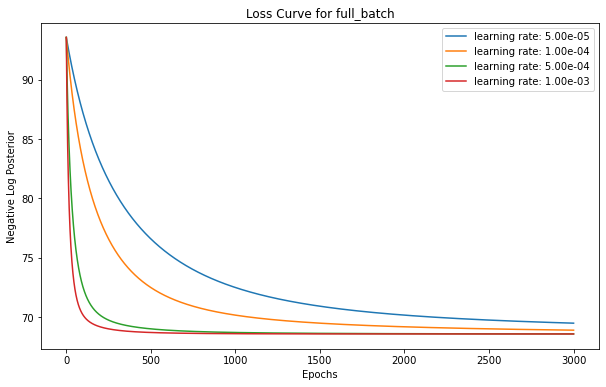

In [24]:
gradient_descent(name='iris', update_rule='full_batch', learning_rates=[5e-5, 1e-4, 5e-4, 1e-3], total_epochs=3000)

The results are for SGD trained to 800 epochs
--------------------------------------------------------------------------------
Learning Rate=5.00e-06
Best Epoch=800, Best Iteration=107929
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1642
--------------------------------------------------------------------------------
Learning Rate=1.00e-05
Best Epoch=800, Best Iteration=108000
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1504
--------------------------------------------------------------------------------
Learning Rate=5.00e-05
Best Epoch=591, Best Iteration=79784
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1200
--------------------------------------------------------------------------------
Learning Rate=1.00e-04
Best Epoch=300, Best Iteration=40500
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1213
--------------------------------------------------------------------------------
SGD took 10

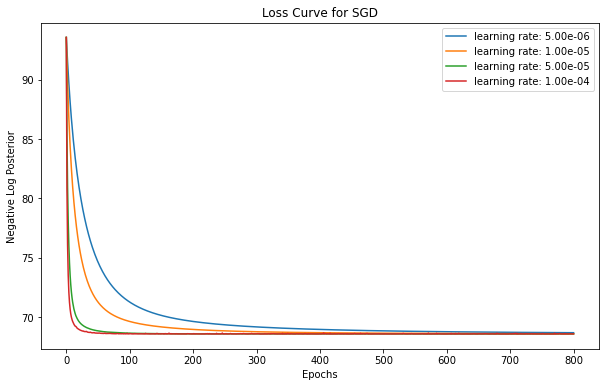

In [13]:
gradient_descent(name='iris', update_rule='SGD', learning_rates=[5e-6, 1e-5, 5e-5, 1e-4], total_epochs=800)

In [14]:
# This version of the gradient descent function will plot the SGD and full_batch negative log loss curves on the same plot for a particular learning rate and epoch
def comparative_gradient_descent(name='iris', update_rules=['full_batch', 'SGD'], learning_rate=1e-4, total_epochs=1000):
    np.random.seed(1000)
    print("The results are for learning_rate=%.2e trained to %d epochs" %(learning_rate, total_epochs))
    # load datasets, merge train and validation, add a column of ones to the x values to accomodate the bias column in the w 
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset(name)
    # consider only the 2nd response to determine whether the flower is an iris versicolour or not 
    y_train, y_valid, y_test = y_train[:,1,None], y_valid[:,1,None], y_test[:,1,None]
    x_train_val = np.vstack([x_valid, x_train])
    y_train_val = np.vstack([y_valid, y_train])
    # add a ones column to the training set to accomodate the bias column in w 
    x_train_val = np.hstack([np.ones((x_train_val.shape[0], 1)), x_train_val])
    x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
    plt.figure(figsize=(10,6))
    # initialize the epochs_array which will be used for plotting 
    epochs_array=np.arange(total_epochs+1)

    for update_rule in update_rules:
        best_iteration = 0 
        best_epoch = 0 
        # initialize the final MAP estimate of w and the lowest log loss value 
        w_final = np.zeros((x_train_val.shape[1], 1))
        smallest_loss = np.inf
        # initialize w = 0, initialize list of log loss values that will be plotted
        w = np.zeros((x_train_val.shape[1], 1))
        neg_log_losses = [compute_log_loss(x_train_val, y_train_val, w)]
        total_iterations_needed = 0 
        # iterate through the inputted number of epochs 
        for epoch in range(total_epochs):
            if update_rule == 'SGD':
                randomized_indices = np.random.permutation(x_train_val.shape[0]) 
                for i, mini_batch_index in enumerate(randomized_indices):
                    picked_x = np.reshape(x_train_val[mini_batch_index], (1, x_train_val.shape[1]))
                    picked_y = np.reshape(y_train_val[mini_batch_index], (1, y_train_val.shape[1]))
                    gradient = compute_gradient(picked_x, picked_y, w, scale=x_train_val.shape[0]) 
                    w = w - learning_rate * gradient 
                    # compute the new loss with updated w, decide whether to change the best w based on comparison of the newest loss versus current smallest loss 
                    # the loss should be computed over the entire dataset 
                    new_loss = compute_log_loss(x_train_val, y_train_val, w) 
                    if smallest_loss > new_loss:
                        smallest_loss = new_loss
                        best_iteration = total_iterations_needed + 1 
                        best_epoch = epoch + 1 
                        w_final = w.copy()
                    total_iterations_needed += 1 
            elif update_rule == 'full_batch':
                # just compute the gradient using the entire dataset during each iteration 
                gradient = compute_gradient(x_train_val, y_train_val, w)
                w = w - learning_rate * gradient 
                new_loss = compute_log_loss(x_train_val, y_train_val, w)
                if smallest_loss > new_loss:
                    smallest_loss = new_loss
                    best_iteration = total_iterations_needed + 1
                    best_epoch = epoch + 1 
                    w_final = w.copy()
                total_iterations_needed += 1 
            else:
                print('Wrong Method')
                return 
            # append the neg_log_losses after each epoch, used later for plotting 
            neg_log_losses.append(new_loss)
            
        # plot the log loss curve with respect to epoch 
        plt.plot(epochs_array, neg_log_losses, label="%s"%update_rule)
        plt.legend(loc=0)
        plt.title('Comparative Loss Curves for Learning Rate=%.2e' %learning_rate)
        plt.ylabel('Negative Log Posterior')
        plt.xlabel('Epochs')

        print('-'*80)
        print("Update Rule=%s" %update_rule)
        print('Best Epoch=%d, Best Iteration=%d' %(best_epoch, best_iteration)) 

        pred = sigmoid(x_test, w_final)
        accuracy = evaluate_likelihood_accuracy(pred, y_test)
        log_likelihood = compute_log_likelihood(x_test, y_test, w_final)
        print("Test Accuracy value: %.4f" % accuracy)
        print("Test (Positive) Log-Likelihood value: %.4f" % log_likelihood)
    print('-' * 80)
    print('Trained for %d iterations in total for %d epochs' %(total_iterations_needed, total_epochs))

The results are for learning_rate=5.00e-04 trained to 500 epochs
--------------------------------------------------------------------------------
Update Rule=full_batch
Best Epoch=500, Best Iteration=500
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1257
--------------------------------------------------------------------------------
Update Rule=SGD
Best Epoch=282, Best Iteration=38058
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1286
--------------------------------------------------------------------------------
Trained for 67500 iterations in total for 500 epochs


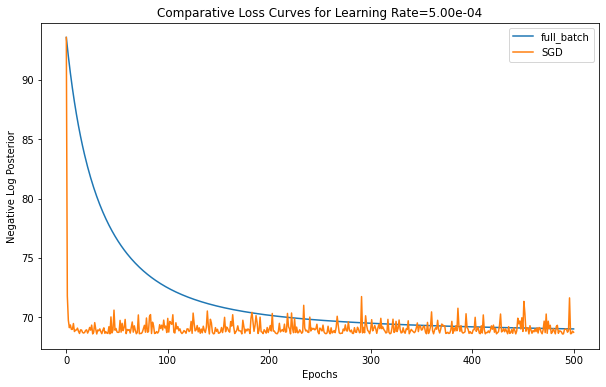

In [15]:
comparative_gradient_descent(learning_rate=5e-4, total_epochs=500)

The results are for learning_rate=1.00e-03 trained to 500 epochs
--------------------------------------------------------------------------------
Update Rule=full_batch
Best Epoch=500, Best Iteration=500
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1554
--------------------------------------------------------------------------------
Update Rule=SGD
Best Epoch=402, Best Iteration=54247
Test Accuracy value: 0.7333
Test (Positive) Log-Likelihood value: -7.1227
--------------------------------------------------------------------------------
Trained for 67500 iterations in total for 500 epochs


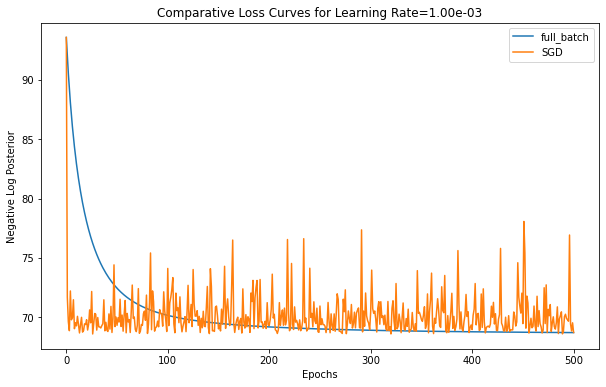

In [16]:
comparative_gradient_descent(learning_rate=1e-3, total_epochs=500)

# Q2(c). Fully Connected Neural Network
- Considering 100 neurons per hidden layer, plot the stochastic estimate of the training set negative log-likelihood versus iteration number during training.
- Draw the validation set negative log-likelihood versus interation number in the same plot. 
- Report test negative log-likelihood and test set accuracy for the final model. 

In [17]:
def evaluate_categorical_accuracy(predictions, y_test):
    accuracy = np.count_nonzero(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    return accuracy

# define the training function, return the parameters produced from training 
def train_and_evaluate_nn_model(name='mnist_small', neurons_per_layer=100, mini_batch_size=250, learning_rate=1e-4, total_iterations=1000):
    np.random.seed(100)
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
    # define the nll_gradients function 
    nll_gradients = value_and_grad(negative_log_likelihood, argnum=[0,1,2,3,4,5])
    # Intialize the weights randomly using ReLU Initialization taught in lecture, initialize biases to zero
    '''
    W1 : (M, 784) weights of first (hidden) layer
    W2 : (M, M) weights of second (hidden) layer
    W3 : (10, M) weights of third (output) layer
    b1 : (M, 1) biases of first (hidden) layer
    b2 : (M, 1) biases of second (hidden) layer
    b3 : (10, 1) biases of third (output) layer
    '''
    W1 = np.random.randn(neurons_per_layer, x_train.shape[1]) / np.sqrt(x_train.shape[1]/2)
    W2 = np.random.randn(neurons_per_layer, W1.shape[0]) / np.sqrt(W1.shape[0]/2)
    W3 = np.random.randn(y_train.shape[1], neurons_per_layer) / np.sqrt(W2.shape[0]/2) 
    b1 = np.zeros((neurons_per_layer, 1)) 
    b2 = np.zeros((neurons_per_layer, 1)) 
    b3 = np.zeros((y_train.shape[1], 1)) 
    
    # initialize the minimum negative log likelihood and the epoch number at which it occurred  
    min_validation_nll = np.inf
    # initialize the negative log likelihood lists for training and validation which will be plotted 
    train_nll_values = []
    validation_nll_values =[] 
    iterations_list = [] 
    # iterate through the iterations from 1 to the total_iterations
    i = 0
    while i < total_iterations:
        # during each iteration, we draw 250 samples and use them to update our gradients and parameters, we want to ensure that the samples are pre-randomized  
        # to do this, I will first randomly shuffle the array of indices from 0 to N-1, reshape it into 40 chunks each with 250 indices 
        randomized_indices = np.random.permutation(x_train.shape[0]).reshape(-1, mini_batch_size)
        # iterate through the randomized mini-batche indices
        for mini_batch_indices in randomized_indices:
            # compute the negative log likelihood and gradients for this particular minibatch 
            # in contrast to Q1, the nll_gradients function computes gradient and loss at the same time, so the loss computed is only for this minibatch 
            (nll, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad)) = nll_gradients(W1, W2, W3, b1, b2, b3, x_train[mini_batch_indices], y_train[mini_batch_indices])
            # update the parameters with the gradients 
            W1 = W1 - learning_rate * W1_grad
            W2 = W2 - learning_rate * W2_grad
            W3 = W3 - learning_rate * W3_grad
            b1 = b1 - learning_rate * b1_grad
            b2 = b2 - learning_rate * b2_grad
            b3 = b3 - learning_rate * b3_grad
            # need to compute the nll value over ALL training samples, hence I make this approximation using the nll over 1 minibatch 
            training_nll = nll * x_train.shape[0] / mini_batch_size
            train_nll_values.append(training_nll)
            # compute the validation nll value and append to validation values list
            validation_nll = negative_log_likelihood(W1, W2, W3, b1, b2, b3, x_valid, y_valid)
            validation_nll_values.append(validation_nll)
            # append to iterations list the current iteration, add to the current iteration value 
            iterations_list.append(i)
            # print training and validation nll every 500 iterations 
            if i==0 or (i+1) % 500 == 0: 
                print('On iteration %d, training nll = %.4f, validation nll = %.4f' % (i+1, nll, validation_nll))
            # update the parameters based on comparing the validation nll against current minimum 
            if validation_nll < min_validation_nll:
                min_validation_nll = validation_nll
                best_iteration = i 
                final_train_nll = training_nll
                (best_W1, best_W2, best_W3, best_b1, best_b2, best_b3) = (W1.copy(), W2.copy(), W3.copy(), b1.copy(), b2.copy(), b3.copy())
            i += 1 
    print('-' * 80)
    print('The results are with learning rate: %.2e' %learning_rate)
    print('Best model was trained to iteration: %d' %best_iteration)
    print('Training nll with final model: %.4f' %final_train_nll)
    print('Validation nll with final model: %.4f' %min_validation_nll)

    # plot the training and validation nll curves over iterations 
    plt.figure(figsize=(10,6))
    plt.plot(iterations_list, train_nll_values, label='Training NLL Values')
    plt.plot(iterations_list, validation_nll_values, label='Validation NLL Values')
    plt.title('Training and Validation NLL curves for Learning Rate=%.2e' %learning_rate)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.legend(loc=0)

    # plot the averaged training and validation nll for similar scaled visualization
    plt.figure(figsize=(10,6))
    plt.plot(iterations_list, [x / x_train.shape[0] for x in train_nll_values], label='Training NLL Values')
    plt.plot(iterations_list, [x / x_valid.shape[0] for x in validation_nll_values], label='Validation NLL Values')
    plt.title('Average Training and Validation NLL curves for Learning Rate=%.2e' %learning_rate)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.legend(loc=0)

    # now perform testing on test set 
    test_nll = negative_log_likelihood(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3, x_test, y_test)
    print('The test set nll is: %.4f' %test_nll)
    pred = forward_pass(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3, x_test)
    accuracy = evaluate_categorical_accuracy(pred, y_test)
    print('The test set accuracy is: %.4f' %accuracy)
    return (best_W1, best_W2, best_W3, best_b1, best_b2, best_b3)


On iteration 1, training nll = 930.3870, validation nll = 3962.2051
On iteration 500, training nll = 3.7813, validation nll = 159.1157
On iteration 1000, training nll = 0.8998, validation nll = 170.9306
On iteration 1500, training nll = 0.4224, validation nll = 178.5951
On iteration 2000, training nll = 0.3496, validation nll = 185.7774
--------------------------------------------------------------------------------
The results are with learning rate: 1.00e-03
Best model was trained to iteration: 486
Training nll with final model: 172.3847
Validation nll with final model: 150.4448
The test set nll is: 156.9127
The test set accuracy is: 0.9510


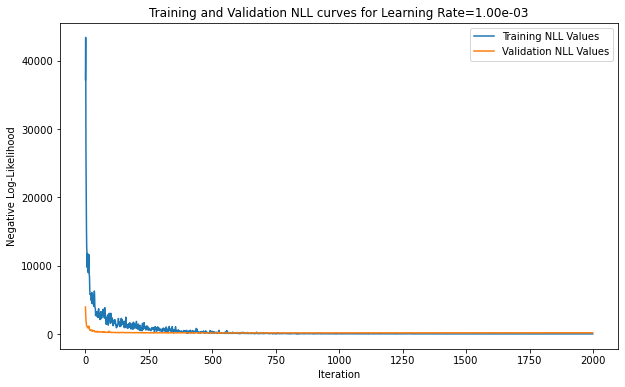

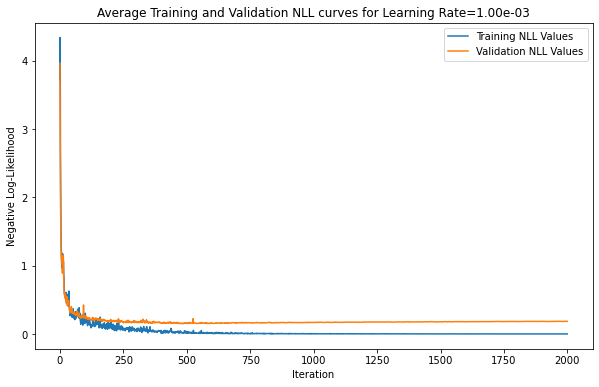

In [18]:
(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3) = train_and_evaluate_nn_model(learning_rate=1e-3, total_iterations=2000)

# Q2(d). Plot Unconfident Test Digits

In [19]:
def plot_unconfident_digits(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3, x_test, threshold=0.5):
    # need to convert the log-softmax value from the forward pass back into conditional probability of Pr(y=1 | w, x)
    f_hat_probability = np.exp(forward_pass(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3, x_test))
    # for each test_set sample, select the top conditional probability out of the 10 categories
    largest_probability = np.max(f_hat_probability, axis=1)
    unconfident_sample_indices = np.where(largest_probability < threshold)[0]
    for sample_index in unconfident_sample_indices:
        plt.figure()
        plot_digit(x_test[sample_index])
        print('Conditional Probability of Prediction: %.4f' %largest_probability[sample_index])

Conditional Probability of Prediction: 0.4883
Conditional Probability of Prediction: 0.4500
Conditional Probability of Prediction: 0.3991
Conditional Probability of Prediction: 0.2737
Conditional Probability of Prediction: 0.4932
Conditional Probability of Prediction: 0.3453
Conditional Probability of Prediction: 0.4132
Conditional Probability of Prediction: 0.3723
Conditional Probability of Prediction: 0.4895


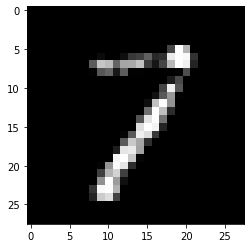

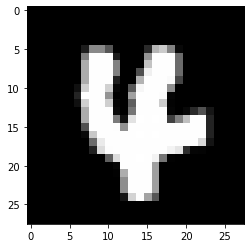

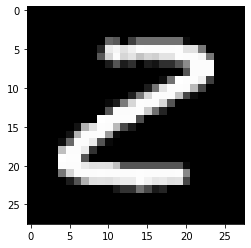

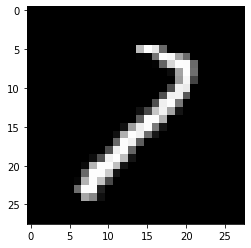

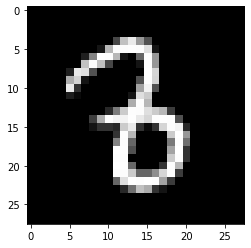

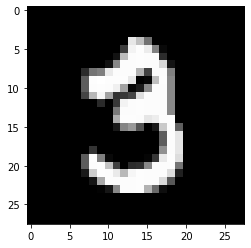

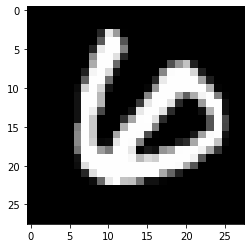

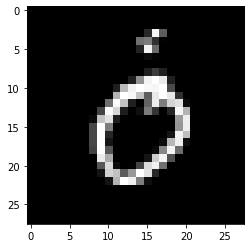

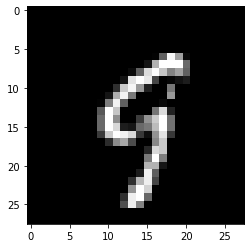

In [20]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
plot_unconfident_digits(best_W1, best_W2, best_W3, best_b1, best_b2, best_b3, x_test, 0.5)